## Summarize the data scraped from the excel workbook, and check it against previously calculated metadata.

In [1]:
import os
import pandas as pd  # for data storage and manipulation
import seaborn as sns  # for plotting

# common.py is a local file with shared constants
import common

In [2]:
comments = {}  # Log any comments through processing and report them all at the end.

def safe_load(f):
    if os.path.isfile(f):
        df = pd.read_csv(f, sep='\t', index_col=0)
        print("read {:,} records from {}".format(len(df.index), f))
    else:
        print("01_collect_data.ipynb needs to be run before any analyses.")
    return df

data = safe_load(common.data_file)
meta = safe_load(common.meta_file)

read 5,220 records from data.tsv
read 145 records from meta.tsv


### Calculate hit rates and compare with those in Excel

In [3]:
""" Aggregate the hits and misses, by sheet, to facilitate calculating a hit rate. """

df_hitmiss = pd.crosstab(data['sheet'], data['Hit_Miss_raw'])
meta['py_hit_rate'] = df_hitmiss['\'Hit\''] / (df_hitmiss['\'Miss\''] + df_hitmiss['\'Hit\''])
meta.to_csv(common.meta_file, sep="\t")

In [4]:
""" Find and report any differences between my calculations and those in the Excel workbook. """

df_diffs = meta[meta['xl_hit_rate'] != meta['py_hit_rate']]
comments = ["Checking that python-calculated hit rates match Excel hit rates.", ]
comments.append("{} hit rate{} differed:".format(
    len(df_diffs), "s" if len(df_diffs.index) > 1 else ""
))
for diff in df_diffs.itertuples():
    comments.append("{} reported {:.2%}; I calculated {:.2%}.".format(
        getattr(diff, 'Index'), getattr(diff, 'xl_hit_rate'), getattr(diff, 'py_hit_rate')
    ))
comments.append("The excel sheet formula excluded one 'Hit' cell, reducing the hit rate.")
comments.append("This notebook therefore seems accurate, although it differs from the spreadsheet.")
print(" ".join(comments))

Checking that python-calculated hit rates match Excel hit rates. 1 hit rate differed: ys00-09-22-2016-15-12 reported 58.33%; I calculated 61.11%. The excel sheet formula excluded one 'Hit' cell, reducing the hit rate. This notebook therefore seems accurate, although it differs from the spreadsheet.


In [5]:
df_hitmiss.sample(4)

Hit_Miss_raw,'Hit','Miss'
sheet,,
ab02-08-15-2018-13-11,19,17
jb99-10-18-2016-15-03,18,18
vm99-05-24-2016-13-54,20,16
ra01-06-09-2016-12-22,14,22


In [6]:
meta.sample(4)

,pid,xl_hit_rate,state_anxiety,trait_anxiety,session,participant,sex,py_hit_rate
sheet,,,,,,,,
ad99-05-24-2016-15-59,ad99,0.583333,35,31,1,ad99,M,0.583333
mm00-01-18-2018-12-08,mm00,0.500000,22,31,1,mm00,F,0.500000
zl98-10-18-2016-09-47,zl98,0.500000,35,42,1,zl98,M,0.500000
ms00-01-18-2018-10-59,ms00,0.527778,28,28,1,ms00,F,0.527778


Seems symmetrical and roughly normal. But is there a bimodal distribution?


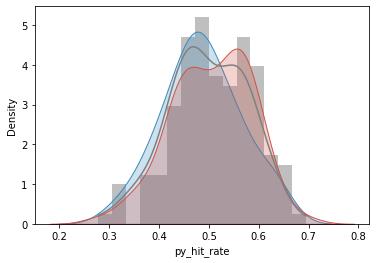

In [7]:
# Our parametric statistics all assume our results are normally distributed, among other things. Are they?
# Colors and color palettes are defined in common.py
p = sns.histplot(meta['py_hit_rate'], bins=15, kde=True, stat="density", linewidth=0, color='gray')
p = sns.kdeplot(meta[meta['sex'] == 'M']['py_hit_rate'], color=common.bluish, label="male", shade=True, ax=p)
p = sns.kdeplot(meta[meta['sex'] == 'F']['py_hit_rate'], color=common.reddish, label="female", shade=True, ax=p)

print("Seems symmetrical and roughly normal. But is there a bimodal distribution?")
p.get_figure().savefig('hit_rate_distribution.png')

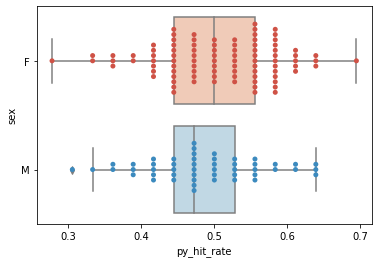

In [8]:
# Another way to look at the same data, nothing new, and perhaps harder to see
p = sns.boxplot(x='py_hit_rate', y='sex', data=meta, palette=common.light_palette)
p = sns.swarmplot(x='py_hit_rate', y='sex', data=meta, palette=common.dark_palette, ax=p)